# Hair follicle (ATAC-seq + RNA-seq)

In this tutorial you will analyze multimodal hair follicle single-cell data with additional RNA velocity information.

Data comes from [Ma, Sai, et al. "Chromatin potential identified by shared single-cell profiling of RNA and chromatin." Cell 183.4 (2020): 1103-1116.](https://www.sciencedirect.com/science/article/pii/S0092867420312538) and consists of two single-cell SHARE-seq modalities: ATAC-seq (chromatin accessibility) and RNA-seq (gene expression). Raw ATAC-seq data is available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597) and raw RNA-seq data [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608). Data comes from female mouse dorsal skin, but we will work on hair follicle subset.

In [1]:
import scvelo as scv

import anndata
import pandas as pd
import numpy as np
import ocelli as oci

import matplotlib.pyplot as plt

## Preprocess RNA-seq

Load necessary packages.

In [36]:
import scanpy as sc
from os.path import join
import pandas as pd

data_folder = '../../../../data/hair-follicle'

Apart from modality count matrices, when visualizing multimodal data, Ocelli can take into account precomputed intercellular transitions. Here, we shall use transitions from the [scVelo](https://www.nature.com/articles/s41587-020-0591-3) algorithm (implemented in [Python](https://scvelo.readthedocs.io)). scVelo describes the rate of gene expression change for an individual gene at a given time point based on the ratio of its unspliced and spliced mRNA. We will guide you through the calculation of scVelo velocities. The first step is to calculate unspliced and spliced gene expression layers using the command line tool [Velocyto](http://velocyto.org), which we ran on [source bam files](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608). It outputs a ``loom`` file with the gene expression count matrix ``adata.X``, and its unspliced ``adata.layers['unspliced']`` and spliced ``adata.layers['spliced']`` layers.

In [16]:
rna_seq = sc.read_loom(join(data_folder, 'skin_XCISH.loom'))
rna_seq.var_names_make_unique()

rna_seq

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 64840 × 27998
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Raw count matrix has 27998 genes with metadata stored in ``adata.var``.

In [17]:
rna_seq.var

,Accession,Chromosome,End,Start,Strand
Gene,,,,,
Xkr4,ENSMUSG00000051951,1,3671498,3205901,-
Gm37381,ENSMUSG00000102343,1,3986215,3905739,-
Rp1,ENSMUSG00000025900,1,4409241,3999557,-
Rp1-1,ENSMUSG00000109048,1,4409187,4292981,-
Sox17,ENSMUSG00000025902,1,4497354,4490931,-
...,...,...,...,...,...
Gm28672,ENSMUSG00000100492,Y,89225296,89222067,+
Gm28670,ENSMUSG00000099982,Y,89394761,89391528,+
Gm29504,ENSMUSG00000100533,Y,90277501,90275224,+


And 64840 cells with metadata stored in ``adata.obs``.

In [4]:
rna_seq.obs

""
CellID
"skin_XCISH:R1.01,R2.01,R3.06,P1.55"
"skin_XCISH:R1.01,R2.01,R3.31,P1.53"
"skin_XCISH:R1.01,R2.01,R3.43,P1.56"
"skin_XCISH:R1.01,R2.01,R3.42,P1.55"
"skin_XCISH:R1.01,R2.01,R3.36,P1.53"
...
"skin_XCISH:R1.96,R2.95,R3.90,P1.54"
"skin_XCISH:R1.96,R2.96,R3.12,P1.55"
"skin_XCISH:R1.96,R2.96,R3.23,P1.53"


In the following preprocessing steps you will:

- Match RNA-seq barcodes with ATAC-seq barcodes,
- Select the hair follicle subset of the data,
- Remove doublets,
- Filter out low qualaity cells and genes

Let's compare the barcode format from ATAC-seq data for easier intermodality cell matching. ATAC-seq barcodes look as follows.

In [25]:
atac_barcodes = pd.read_csv(join(data_folder, 'GSM4156597_skin.late.anagen.barcodes.txt'), sep='\t', header=None, names=['barcode'])

atac_barcodes

,barcode
0,R1.01.R2.01.R3.06.P1.55
1,R1.01.R2.03.R3.68.P1.55
2,R1.01.R2.05.R3.15.P1.53
3,R1.01.R2.05.R3.40.P1.55
4,R1.01.R2.05.R3.49.P1.55
...,...
34769,R1.92.R2.79.R3.05.P1.56
34770,R1.93.R2.20.R3.18.P1.53
34771,R1.93.R2.80.R3.62.P1.55
34772,R1.93.R2.91.R3.82.P1.56


After a fast unification of RNA-seq barcodes and selection of cells only present in ATAC-seq modality, you are left with 34774 cells.

In [27]:
rna_seq.obs.index = [index.split(':')[1].replace(',', '.') for index in rna_seq.obs.index]
rna_seq = rna_seq[list(atac_barcodes['barcode'])]

rna_seq

View of AnnData object with n_obs × n_vars = 34774 × 27998
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Now add to the cell metadata cell type annotations available in [the same place](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597). Then select hair follicle subpopulation, which includes TAC-1, TAC-2, IRS, Medulla and Hair shaft cells.

In [28]:
celltypes = list(pd.read_csv(join(data_folder, 'GSM4156597_skin_celltype.txt'), sep='\t')['celltype'])
rna_seq.obs['celltype'] = celltypes

rna_seq = rna_seq[rna_seq.obs['celltype'].isin(['TAC-1', 'TAC-2', 'IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])]

rna_seq

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


View of AnnData object with n_obs × n_vars = 7197 × 27998
    obs: 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Remove doublets. The formula for the number of collisions ``n_collisions`` is taken from [the original paper](https://www.sciencedirect.com/science/article/pii/S0092867420312538).

In [30]:
import scrublet as scr
import numpy as np

D, N = 884736, rna_seq.shape[0]
n_collisions = N - D + D * (((D - 1) / D)**N)

scrublet = scr.Scrublet(rna_seq.X, expected_doublet_rate=n_collisions / N)
doublet_scores, predicted_doublets = scrublet.scrub_doublets()

threshold = np.percentile(doublet_scores, 100 * (1 - (n_collisions / N)))

rna_seq.obs['doublet_scores'] = doublet_scores
rna_seq = rna_seq[rna_seq.obs['doublet_scores'] < threshold]

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.04
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 0.4%
	Estimated  = 0.0%
Elapsed time: 4.6 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if sys.path[0] == "":


Filter out cells expressed for less than 20 genes. Also, leave genes with at least 20 expressed cells (shared unspliced and spliced layers).

In [32]:
import scvelo as scv

sc.pp.filter_cells(rna_seq, min_genes=20)
scv.pp.filter_genes(rna_seq, min_shared_cells=20)

rna_seq

AnnData object with n_obs × n_vars = 7164 × 2477
    obs: 'celltype', 'doublet_scores', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

After all filterings, we are left with 7164 cells and 2477 genes. You can proceed to topic modeling.

In [34]:
import ocelli as oci

SEED = 17

oci.pp.LDA(rna_seq, n_components=10, output_key='lda', verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LDA's cell-topic distributions are saved in ``rna_seq.obsm['lda']``.

Now, last but not least, let us focus RNA velocity estimation. To prepare the count the count matrix, you need to perform the following steps:

- Normalize the count matrix,
- Select a subset of highly variable genes (RNA velocity is estimated only on them),
- Logarithmize the count matrix.

In [37]:
scv.pp.normalize_per_cell(rna_seq, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(rna_seq, n_top_genes=1000)
scv.pp.log1p(rna_seq)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.


Now, finally, estimate velocities and calculate the velocity graph. The velocity graph is saved in ``rna_seq.uns['velocity_graph']`` as a square sparse ``scipy.sparse.csr_matrix`` of shape ``(n_cells, n_cells)``. It stores intercellular transitions. A higher value translates to a higher transition velocity between cells.

In [38]:
scv.tl.velocity(rna_seq, mode='stochastic')
scv.tl.velocity_graph(rna_seq)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/7164 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


That's all, now ATAC-seq!

## Preprocess ATAC-seq

In [12]:
from scipy.io import mmread

atac_X = mmread(open(join(data_folder, 'GSM4156597_skin.late.anagen.counts.txt'), 'r')).T.tocsr()

In [13]:
atac_obs = pd.read_csv(join(data_folder, 'GSM4156597_skin_celltype.txt'), sep='\t')
atac_obs.index = list(atac_obs['rna.bc'])
atac_obs = atac_obs.drop(['atac.bc', 'rna.bc'], axis=1)
atac_obs

,celltype
R1.01.R2.01.R3.06.P1.55,Dermal Fibroblast
R1.01.R2.03.R3.68.P1.55,Dermal Fibroblast
R1.01.R2.05.R3.15.P1.53,Dermal Fibroblast
R1.01.R2.05.R3.40.P1.55,Dermal Fibroblast
R1.01.R2.05.R3.49.P1.55,Dermal Fibroblast
...,...
R1.92.R2.79.R3.05.P1.56,Melanocyte
R1.93.R2.20.R3.18.P1.53,Melanocyte
R1.93.R2.80.R3.62.P1.55,Melanocyte
R1.93.R2.91.R3.82.P1.56,Melanocyte


In [14]:
atac_seq = anndata.AnnData(atac_X, obs=atac_obs)
atac_seq

AnnData object with n_obs × n_vars = 34774 × 344592
    obs: 'celltype'

In [15]:
atac_seq = atac_seq[rna_seq.obs.index]

In [16]:
scp.pp.filter_genes(atac_seq, min_cells=20)
atac_seq

AnnData object with n_obs × n_vars = 7164 × 242929
    obs: 'celltype'
    var: 'n_cells'

In [17]:
oci.pp.LDA(atac_seq, n_components=10, verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

## Prepare multimodal AnnData

In [19]:
from scipy.sparse import csr_matrix

adata = anndata.AnnData(csr_matrix(np.zeros(rna_seq.shape)))

adata.obs = rna_seq.obs
adata.obsm['rna_seq'] = rna_seq.obsm['lda']
adata.obsm['atac_seq'] = atac_seq.obsm['lda']
adata.uns['velocity_graph'] = rna_seq.uns['velocity_graph']
adata.layers['velocity'] = rna_seq.layers['velocity']
adata.uns['modalities'] = ['rna_seq', 'atac_seq']

## Calculate multi-view diffusion maps components

In [39]:
import ocelli as oci

adata

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

AnnData object with n_obs × n_vars = 7164 × 1000
    obs: 'celltype', 'doublet_scores', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    uns: 'modalities', 'velocity_graph'
    obsm: 'atac_seq', 'rna_seq'
    layers: 'velocity'

In [40]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)

[rna_seq] 20 nearest neighbors calculated.
[atac_seq] 20 nearest neighbors calculated.


2022-10-04 22:59:50,071	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal cell-specific weights estimated.


In [41]:
oci.tl.MDM(adata, n_components=20, random_state=SEED, verbose=True)

2022-10-04 22:59:56,780	INFO worker.py:1518 -- Started a local Ray instance.


[rna_seq] Unimodal Markov chain calculated
[atac_seq] Unimodal Markov chain calculated
Multimodal Markov chain calculated
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


## Visualize the data

In [42]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.vel_graph(adata, n_edges=3, neighbors_key='X_mdm', verbose=True)

oci.tl.FA2(adata, n_components=3, random_state=SEED, output_key='X_fa2_3d')

[X_mdm] 100 nearest neighbors calculated.
RNA velocity-based graph constructed.


Oct 04, 2022 11:00:15 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 04, 2022 11:00:15 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 7,164 (7,164 added)
Oct 04, 2022 11:00:15 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 21,492 (20,914 added)


*************************25%
*************************50%
*************

************75%
*************************100%
Time = 48.374s


### 3D plots

In [43]:
plot = oci.pl.scatter(adata, x_key='X_fa2_3d', color_key='celltype', cmap='gnuplot', marker_size=1, static=False)
plot.write_html(join(output_folder, '3d-celltype.html'))

In [44]:
adata.obs['w_rna_seq'] = list(adata.obsm['weights']['rna_seq'])
plot = oci.pl.scatter(adata, x_key='X_fa2_3d', color_key='w_rna_seq', cmap='gnuplot', marker_size=1, static=False)
plot.write_html(join(output_folder, '3d-weights-rna.html'))

In [45]:
adata.obs['w_atac_seq'] = list(adata.obsm['weights']['atac_seq'])
plot = oci.pl.scatter(adata, x_key='X_fa2_3d', color_key='w_atac_seq', cmap='gnuplot', marker_size=1, static=False)
plot.write_html(join(output_folder, '3d-weights-atac.html'))

### 2D projections

In [46]:
colors = {'Hair Shaft-cuticle.cortex': '#1a62a5', 
          'IRS': '#a0bae2',
          'Medulla': '#fdac65', 
          'TAC-1': '#289322',
          'TAC-2': '#89db77'}

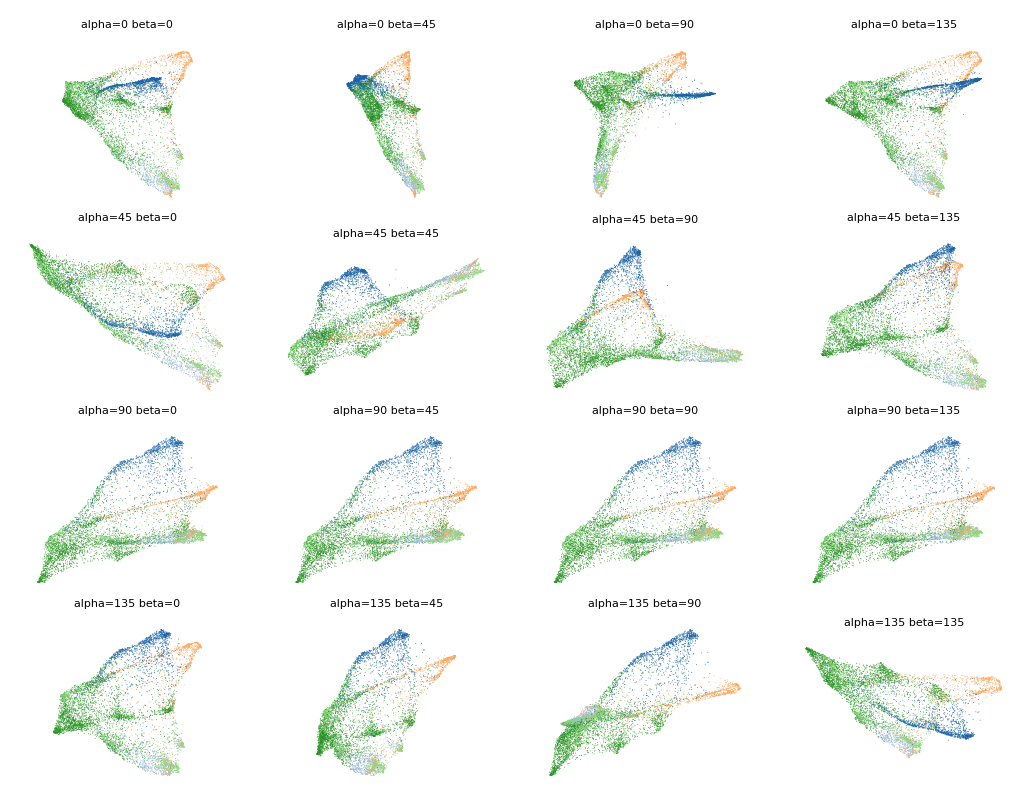

In [47]:
alphas, betas = [0, 45, 90, 135], [0, 45, 90, 135]

fig, ax = plt.subplots(len(alphas), len(betas))

for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        oci.tl.project_2d(adata, x3d_key='X_fa2_3d', output_key='X_proj', alpha=a, beta=b, random_state=SEED)
        ax[i][j].scatter(x=adata.obsm['X_proj'][:, 0],
                         y=adata.obsm['X_proj'][:, 1], 
                         edgecolor='none', s=0.1, 
                         c=[colors[c] for c in adata.obs['celltype']])
        ax[i][j].set_aspect('equal')
        ax[i][j].axis('off')
        ax[i][j].set_title('alpha={} beta={}'.format(a, b), fontsize=4)

In [48]:
oci.tl.project_2d(adata, x3d_key='X_fa2_3d', output_key='X_proj', alpha=0, beta=90)

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

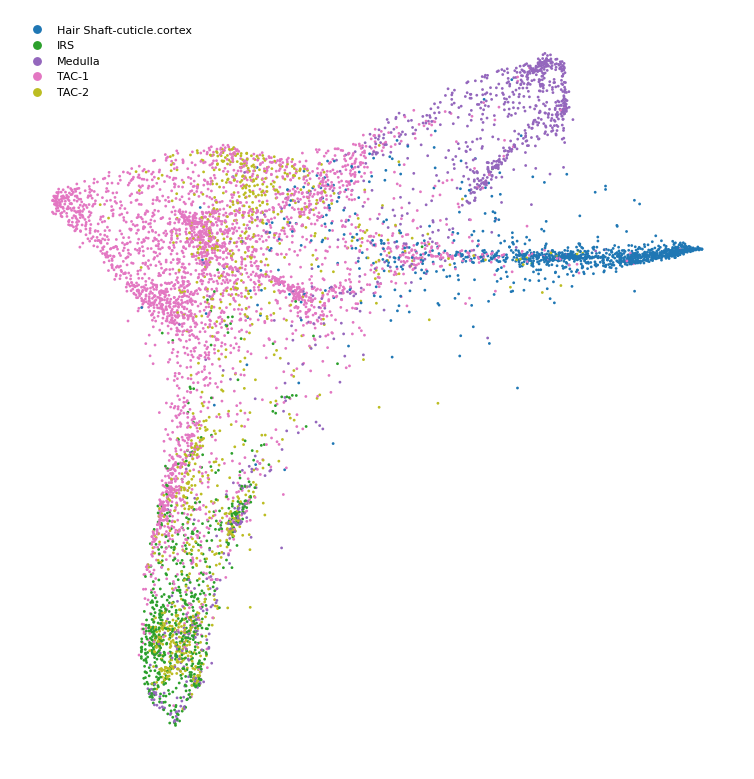

In [49]:
oci.pl.scatter(adata, x_key='X_proj', color_key='celltype', cmap='tab10', marker_size=1)

### Velocity stream

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_proj', embedded velocity vectors (adata.obsm)


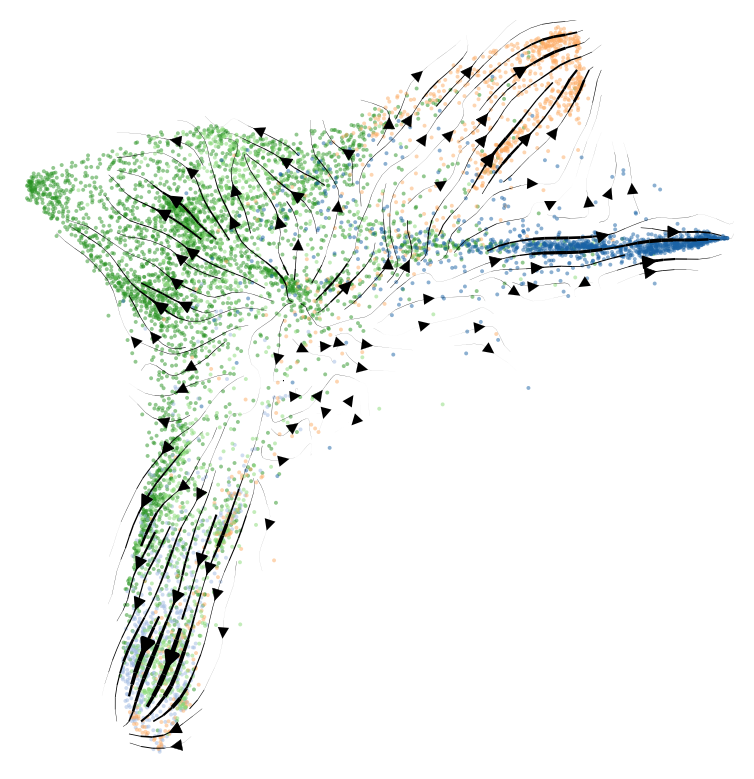

In [50]:
fig, ax = plt.subplots()
scv.pl.velocity_embedding_stream(adata, basis='proj', alpha=0.5, 
                          title='', dpi=200, density=2, 
                          linewidth=1, show=False, ax=ax, color='celltype', palette=colors, size=8, legend_loc='none')
ax.set_aspect('equal')

### Weights

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

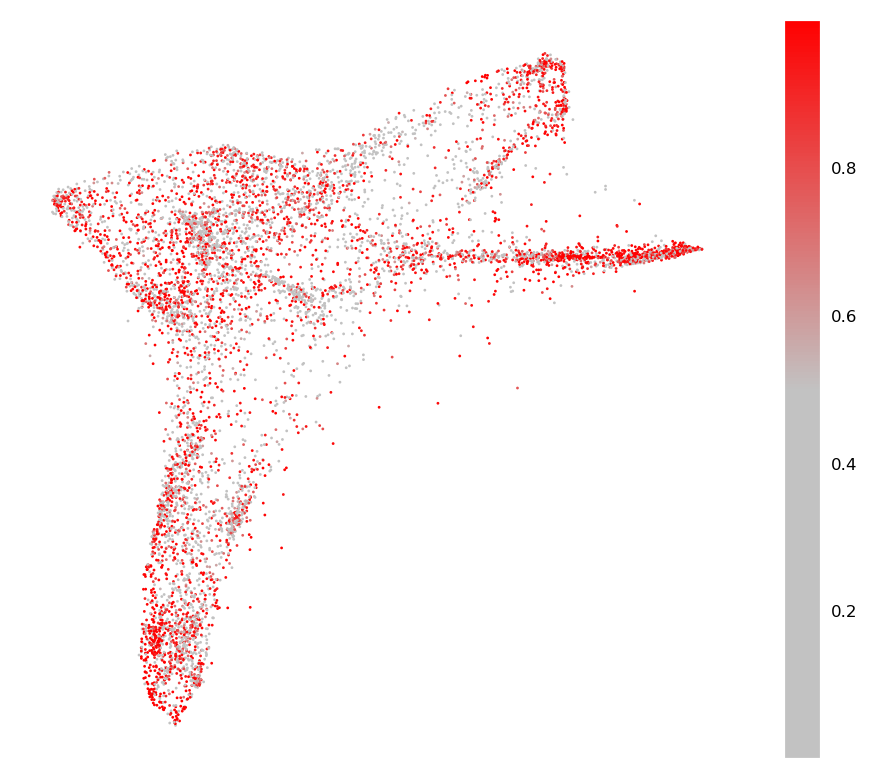

In [51]:
adata.obs['w_rna'] = list(adata.obsm['weights']['rna_seq'])
oci.pl.scatter(adata, 
               x_key='X_proj',
               color_key='w_rna', 
               cmap=mpl.colors.LinearSegmentedColormap.from_list('custom', ['#C2C2C2', '#C2C2C2', '#FF0000'], N=256), 
               marker_size=1)

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

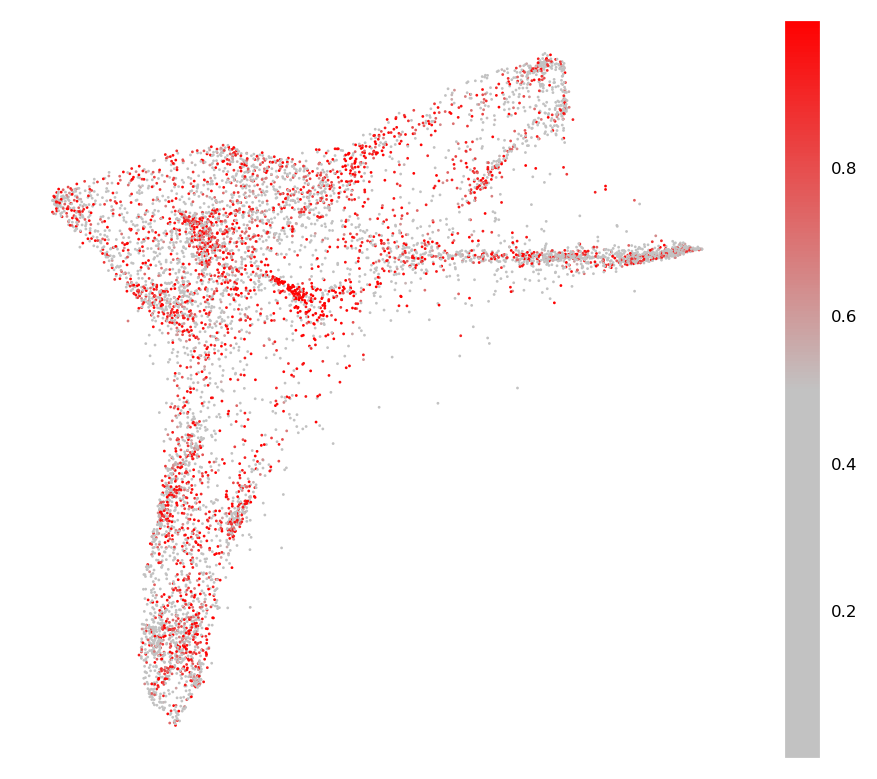

In [52]:
adata.obs['w_atac'] = list(adata.obsm['weights']['atac_seq'])
oci.pl.scatter(adata, 
               x_key='X_proj',
               color_key='w_atac', 
               cmap=mpl.colors.LinearSegmentedColormap.from_list('custom', ['#C2C2C2', '#C2C2C2', '#FF0000'], N=256), 
               marker_size=1)

### Topics

(<Figure size 1280x960 with 11 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>]], dtype=object))

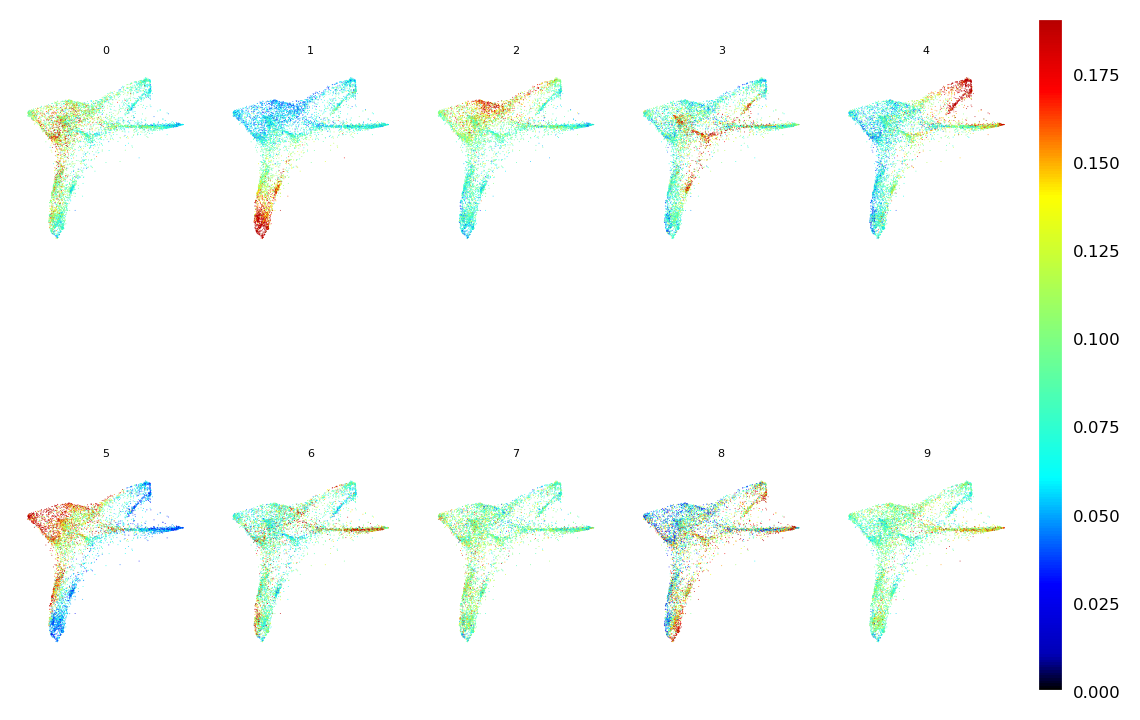

In [53]:
oci.pl.topics(adata, x_key='X_proj', topics_key='rna_seq', marker_size=0.1)

(<Figure size 1280x960 with 11 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>]], dtype=object))

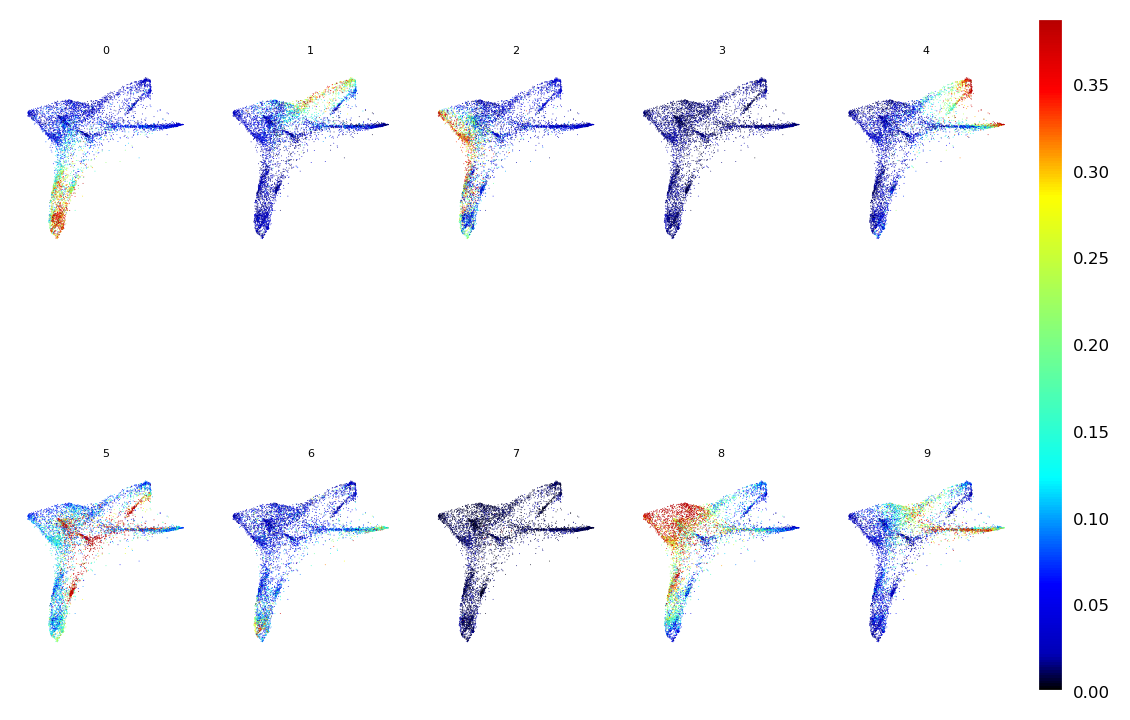

In [54]:
oci.pl.topics(adata, x_key='X_proj', topics_key='atac_seq', marker_size=0.1)